<a href="https://colab.research.google.com/github/MayankMV2/weatherwise-perth-Mayank/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# cell 1
!pip -q install fetch-my-weather pandas matplotlib

In [48]:
# cell 2
CITY = "Perth"
UNITS = "m"
USE_MOCK = False

In [49]:
# cell 3
import requests, pandas as pd, numpy as np

DAYS = 7
lat, lon, tz = -31.9523, 115.8613, "Australia/Perth"  # Perth
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": lat,
    "longitude": lon,
    "daily": [
        "temperature_2m_max",
        "temperature_2m_min",
        "precipitation_sum",
        "precipitation_probability_max",
        "uv_index_max",
        "wind_speed_10m_max",
    ],
    "timezone": tz,
    "forecast_days": DAYS,
}
j = requests.get(url, params=params, timeout=30).json()["daily"]

df = pd.DataFrame(j)
df["date"] = pd.to_datetime(df["time"])
df = df.rename(columns={
    "temperature_2m_min": "tmin_c",
    "temperature_2m_max": "tmax_c",
    "precipitation_sum": "precip_mm",
    "precipitation_probability_max": "precip_prob",
    "wind_speed_10m_max": "wind_max_kmh",
    "uv_index_max": "uv_max",
})[["date","tmin_c","tmax_c","precip_mm","precip_prob","wind_max_kmh","uv_max"]]

print("Rows:", len(df))
df



Rows: 7


,date,tmin_c,tmax_c,precip_mm,precip_prob,wind_max_kmh,uv_max
0,2025-09-21,14.8,23.2,0.0,0,14.8,6.90
1,2025-09-22,15.7,24.9,0.0,0,15.5,6.95
2,2025-09-23,16.2,24.4,0.0,0,11.4,7.05
3,2025-09-24,17.6,24.6,0.0,0,9.7,7.15
4,2025-09-25,17.0,22.2,0.0,0,9.1,7.20
5,2025-09-26,15.8,19.3,0.0,4,22.7,6.85
6,2025-09-27,13.0,16.3,0.0,5,23.5,6.85


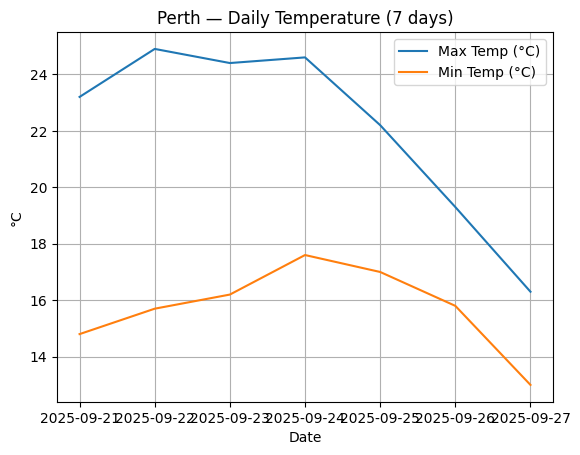

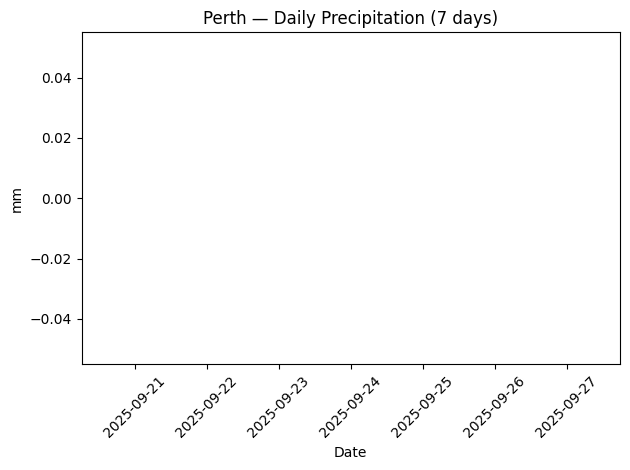

In [50]:
# cell 4
import matplotlib.pyplot as plt

# 1) Daily temperatures (line)
plt.figure()
plt.plot(df["date"], df["tmax_c"], label="Max Temp (°C)")
plt.plot(df["date"], df["tmin_c"], label="Min Temp (°C)")
plt.title("Perth — Daily Temperature (7 days)")
plt.xlabel("Date"); plt.ylabel("°C")
plt.legend(); plt.grid(True); plt.show()

# 2) Daily precipitation (bar)
plt.figure()
plt.bar(df["date"].dt.strftime("%Y-%m-%d"), df["precip_mm"])
plt.title("Perth — Daily Precipitation (7 days)")
plt.xlabel("Date"); plt.ylabel("mm")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()



In [51]:
# cell 5
import re
import pandas as pd

def _day_from(q, today=None):
    """Map 'today', 'tomorrow', weekday names, or YYYY-MM-DD to a date."""
    today = (today or pd.Timestamp.today()).normalize()
    ql = q.lower()
    if "today" in ql: return today
    if "tomorrow" in ql: return today + pd.Timedelta(days=1)
    wds = ["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
    for i, wd in enumerate(wds):
        if wd in ql:
            return today + pd.Timedelta(days=(i - today.weekday()) % 7)
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", ql)
    if m:
        try: return pd.to_datetime(m.group(1)).normalize()
        except: pass
    return None

def _row_for(date_):
    sel = df[df["date"].dt.normalize() == pd.to_datetime(date_).normalize()]
    return None if sel.empty else sel.iloc[0]

def ask(q: str) -> str:
    d = _day_from(q)
    if d is not None:
        r = _row_for(d)
        if r is None:
            rng = f"{df['date'].min().date()} → {df['date'].max().date()}"
            return f"No data for {d.date()} (available {rng})."
        prob = float(r.get("precip_prob", 0) or 0)
        mm   = float(r.get("precip_mm", 0) or 0)
        wind = float(r.get("wind_max_kmh", 0) or 0)
        uv   = float(r.get("uv_max", 0) or 0)
        tmin = float(r["tmin_c"]); tmax = float(r["tmax_c"])

        if re.search(r"umbrella|rain", q, re.I):
            advice = "Yes, take an umbrella." if (prob >= 50 or mm >= 1.0) else "Probably not necessary."
            return f"{advice} Chance {prob:.0f}%, ~{mm:.1f} mm on {d.date()}."
        if re.search(r"wind|gust", q, re.I):
            return f"Peak wind about {wind:.0f} km/h on {d.date()}."
        if re.search(r"\buv\b", q, re.I):
            return f"UV index up to ~{uv:.1f} on {d.date()}."
        if re.search(r"temp|hot|cold|warm|cool|max|min", q, re.I):
            return f"{tmin:.1f}–{tmax:.1f}°C on {d.date()}."
        return f"{d.date()}: {tmin:.1f}–{tmax:.1f}°C, rain {prob:.0f}%, ~{mm:.1f} mm, wind {wind:.0f} km/h, UV {uv:.1f}."

    if df.empty: return "No forecast loaded."
    hottest = df.loc[df["tmax_c"].idxmax()]
    coldest = df.loc[df["tmin_c"].idxmin()]
    wettest = df.loc[df["precip_mm"].idxmax()]
    if re.search(r"hottest|max temp|warmest", q, re.I):
        return f"Hottest day: {hottest['date'].date()} at {hottest['tmax_c']:.1f}°C."
    if re.search(r"coldest|min temp|coolest", q, re.I):
        return f"Coldest day: {coldest['date'].date()} at {coldest['tmin_c']:.1f}°C."
    if re.search(r"rainiest|wettest", q, re.I):
        return f"Wettest day: {wettest['date'].date()} with ~{wettest['precip_mm']:.1f} mm."
    return "Ask about umbrella, wind, UV, temperature, or hottest/coldest/wettest."


In [53]:
# these are the questions in the code

print(ask("Do I need an umbrella tomorrow?"))
print(ask("How windy will it be on Friday?"))
print(ask("What's the UV tomorrow?"))
print(ask("What is the max temp this week?"))
print(ask("Which day is the wettest?"))


Probably not necessary. Chance 0%, ~0.0 mm on 2025-09-22.
Peak wind about 23 km/h on 2025-09-26.
UV index up to ~7.0 on 2025-09-22.
Hottest day: 2025-09-22 at 24.9°C.
Wettest day: 2025-09-21 with ~0.0 mm.


In [54]:
# Cell 6 for using the menu as option
import requests, pandas as pd, matplotlib.pyplot as plt

def fetch_perth(days=7):
    lat, lon, tz = -31.9523, 115.8613, "Australia/Perth"
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat, "longitude": lon, "timezone": tz, "forecast_days": days,
        "daily": ["temperature_2m_max","temperature_2m_min","precipitation_sum",
                  "precipitation_probability_max","uv_index_max","wind_speed_10m_max"],
    }
    j = requests.get(url, params=params, timeout=30).json()["daily"]
    dff = pd.DataFrame(j)
    dff["date"] = pd.to_datetime(dff["time"])
    return dff.rename(columns={
        "temperature_2m_min":"tmin_c","temperature_2m_max":"tmax_c",
        "precipitation_sum":"precip_mm","precipitation_probability_max":"precip_prob",
        "wind_speed_10m_max":"wind_max_kmh","uv_index_max":"uv_max",
    })[["date","tmin_c","tmax_c","precip_mm","precip_prob","wind_max_kmh","uv_max"]]

def menu():
    global df
    while True:
        print("\n[1] Ask a question\n[2] Show temperature chart\n[3] Show rain chart\n[4] Refresh forecast\n[0] Exit")
        c = input("Choose: ").strip()
        if c == "1":
            q = input("Your question: ")
            print(ask(q))
        elif c == "2":
            plt.figure(); plt.plot(df["date"], df["tmax_c"], label="Max (°C)")
            plt.plot(df["date"], df["tmin_c"], label="Min (°C)")
            plt.title("Perth — Daily Temperature (7 days)"); plt.xlabel("Date"); plt.ylabel("°C")
            plt.legend(); plt.grid(True); plt.show()
        elif c == "3":
            mm = df["precip_mm"].fillna(0)
            if (mm == 0).all():
                plt.figure(); plt.plot(df["date"], df["precip_prob"].fillna(0), marker="o")
                plt.title("Perth — Rain Probability (7 days)"); plt.xlabel("Date"); plt.ylabel("%"); plt.grid(True); plt.show()
            else:
                plt.figure(); plt.bar(df["date"].dt.strftime("%Y-%m-%d"), mm)
                plt.title("Perth — Daily Precipitation (7 days)"); plt.xlabel("Date"); plt.ylabel("mm")
                plt.xticks(rotation=45); plt.tight_layout(); plt.show()
        elif c == "4":
            df = fetch_perth(7)
            print("Forecast refreshed.")
        elif c == "0":
            break
        else:
            print("Invalid choice.")

# To use it, run:
# menu()
